In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Wed May 12 09:12:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |  15393MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.2MB/s 


In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


# Data Cleaning

In [ ]:
%cd /content/gdrive/MyDrive/News+LPReports/News-Classifiers

/content/gdrive/MyDrive/News+LPReports/News-Classifiers


In [ ]:
df = pd.read_csv('news_tagged.csv',encoding='cp1252')
df.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,article_number,time_period,company_name,article,revenue_yj,1. revenue,2. pdt_dev,3. mkt_dev,4. partnership,5. mgt change,6. non-mgt change,7. clinical,8. lawsuit,9. fundraising,10. acquisition,entity (WIP),Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,1,0.0,1.0,17Live,"Pioneering live streaming app MeMe Live, which...",NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,1.0,17Live,With the Covid-19 pandemic triggering some pro...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(41484, 33)

In [ ]:
df.dropna(subset = ['1. revenue'], inplace=True)
df.shape

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(3821, 33)

In [ ]:
df1 = df.iloc[:, 0:7]
df1.head()

,ID,article_number,time_period,company_name,article,revenue_yj,1. revenue
0,1,0.0,1.0,17Live,"Pioneering live streaming app MeMe Live, which...",NaN,0.0
1,2,0.0,1.0,17Live,With the Covid-19 pandemic triggering some pro...,NaN,0.0
11,12,0.0,1.0,17Live,"It was later acquired by 17LIVE Group, the ope...",NaN,0.0
24,25,0.0,1.0,17Live,17LIVE’s group of companies consists of 17LIVE...,NaN,1.0
59,61,3.0,6.0,17Live,"Founded in 2017, 17LIVE Japan Inc has attracte...",NaN,0.0


In [ ]:
df1['revenue_yj'].unique()

array([nan,  2.])

In [ ]:
df1['1. revenue'].unique()

array([0., 1.])

In [ ]:
rev = []
for index,row in df1.iterrows():
  if row['1. revenue'] == 1.0:
    revenue = 1
  else:
    if row['revenue_yj'] == 2.0:
      revenue = 1
    else:
      revenue = 0
  
  rev.append(revenue)

In [ ]:
df1['revenue'] = rev
df1.drop(columns=['revenue_yj','1. revenue'], inplace=True)
df1.head()

,ID,article_number,time_period,company_name,article,revenue
0,1,0.0,1.0,17Live,"Pioneering live streaming app MeMe Live, which...",0
1,2,0.0,1.0,17Live,With the Covid-19 pandemic triggering some pro...,0
11,12,0.0,1.0,17Live,"It was later acquired by 17LIVE Group, the ope...",0
24,25,0.0,1.0,17Live,17LIVE’s group of companies consists of 17LIVE...,1
59,61,3.0,6.0,17Live,"Founded in 2017, 17LIVE Japan Inc has attracte...",0


In [ ]:
df1.shape

(3821, 6)

# BERT for revenue

In [ ]:
# Split into train and test 
train, test = train_test_split(df1, test_size = 0.3)

## Encoder

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Build Model

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)
    
    # activation change to sigmoid for multilabel
    # loss is bce loss
    # metrics accuracy

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [ ]:
max_len = 150 # of the sentence
train_input = bert_encode(train.article.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.article.values, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(train.revenue.values, num_classes=2)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('news_rev.h5', monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/10
67/67 [==============================] - 42s 632ms/step - loss: 0.0639 - categorical_accuracy: 0.9836 - val_loss: 0.0508 - val_categorical_accuracy: 0.9869

Epoch 00001: val_categorical_accuracy improved from -inf to 0.98692, saving model to news_rev.h5
Epoch 2/10
67/67 [==============================] - 42s 624ms/step - loss: 0.0221 - categorical_accuracy: 0.9935 - val_loss: 0.0359 - val_categorical_accuracy: 0.9925

Epoch 00002: val_categorical_accuracy improved from 0.98692 to 0.99252, saving model to news_rev.h5
Epoch 3/10
67/67 [==============================] - 42s 624ms/step - loss: 0.0085 - categorical_accuracy: 0.9991 - val_loss: 0.0525 - val_categorical_accuracy: 0.9925

Epoch 00003: val_categorical_accuracy did not improve from 0.99252
Epoch 4/10
67/67 [==============================] - 42s 623ms/step - loss: 0.0044 - categorical_accuracy: 0.9986 - val_loss: 0.0468 - val_categorical_accuracy: 0.9925

Epoch 00004: val_categorical_accuracy did not improve from 0.992

In [ ]:
model.load_weights('news_rev.h5')
test_pred = model.predict(test_input)

In [ ]:
list1 = test_pred.tolist()

test['rev_pred'] = list1
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,article_number,time_period,company_name,article,revenue,rev_pred
36199,38535,1532.0,14.0,Turnkey Lender,The company puts state-of-the-art lending soft...,0,"[0.9999059438705444, 9.401966235600412e-05]"
33259,35369,1410.0,6.0,Sunday,Despite the ongoing pandemic and stringent loc...,1,"[0.0004486858379095793, 0.9995512366294861]"
385,587,22.0,1.0,Ace Turtle Services,"Hence, a brand can easily start selling online...",0,"[0.9996308088302612, 0.00036916317185387015]"
40787,43960,1748.0,24.0,Yotpo,"For example, Ministry of Supply doubled its re...",1,"[0.0005149583448655903, 0.9994850158691406]"
451,666,27.0,6.0,Ace Turtle Services,"In an interaction, Dhruv Bogra, Country Manage...",0,"[0.9895597696304321, 0.010440252721309662]"


In [ ]:
# encode predictions into labels
# first element is for 0
# second element is for 1
def encode(row):
  i = row[0]
  if round(i) == 0:
    val = 1
  else:
    val = 0
  return val

In [ ]:
test['rev_pred'] = test['rev_pred'].apply(lambda x: encode(x))
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,article_number,time_period,company_name,article,revenue,rev_pred
36199,38535,1532.0,14.0,Turnkey Lender,The company puts state-of-the-art lending soft...,0,0
33259,35369,1410.0,6.0,Sunday,Despite the ongoing pandemic and stringent loc...,1,1
385,587,22.0,1.0,Ace Turtle Services,"Hence, a brand can easily start selling online...",0,0
40787,43960,1748.0,24.0,Yotpo,"For example, Ministry of Supply doubled its re...",1,1
451,666,27.0,6.0,Ace Turtle Services,"In an interaction, Dhruv Bogra, Country Manage...",0,0


Test accuracy is 0.993897122929381
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       987
           1       0.98      0.98      0.98       160

    accuracy                           0.99      1147
   macro avg       0.99      0.99      0.99      1147
weighted avg       0.99      0.99      0.99      1147



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

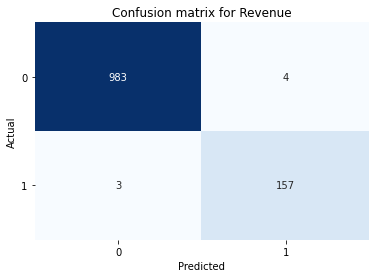

In [ ]:
print('Test accuracy is {}'.format(accuracy_score(test['revenue'], test['rev_pred'])))
print('Classification report:')
print(classification_report(test['revenue'], test['rev_pred']))

# plot confusion matrix
cm = confusion_matrix(test['revenue'], test['rev_pred'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", 
        title="Confusion matrix for Revenue")
plt.yticks(rotation=0)

# BERT for growth

In [ ]:
max_len = 150 # of the sentence
train_input = bert_encode(train.updates.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.updates.values, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(train.growth.values, num_classes=2)

In [ ]:
model2 = build_model(bert_layer, max_len=max_len)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('modelw.h5', monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=1)

train_history = model2.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/10
35/35 [==============================] - 45s 1s/step - loss: 0.5714 - categorical_accuracy: 0.7052 - val_loss: 0.4953 - val_categorical_accuracy: 0.7643

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76429, saving model to modelw.h5
Epoch 2/10
35/35 [==============================] - 37s 1s/step - loss: 0.4981 - categorical_accuracy: 0.7555 - val_loss: 0.4492 - val_categorical_accuracy: 0.7714

Epoch 00002: val_categorical_accuracy improved from 0.76429 to 0.77143, saving model to modelw.h5
Epoch 3/10
35/35 [==============================] - 38s 1s/step - loss: 0.4287 - categorical_accuracy: 0.8093 - val_loss: 0.3971 - val_categorical_accuracy: 0.8143

Epoch 00003: val_categorical_accuracy improved from 0.77143 to 0.81429, saving model to modelw.h5
Epoch 4/10
35/35 [==============================] - 38s 1s/step - loss: 0.3315 - categorical_accuracy: 0.8534 - val_loss: 0.3876 - val_categorical_accuracy: 0.8214

Epoch 00004: val_categorical_accuracy improved fr

In [ ]:
model2.load_weights('modelw.h5')
test_pred_2 = model2.predict(test_input)

In [ ]:
list2 = test_pred_2.tolist()
test['growth_pred'] = list2
test['growth_pred'] = test['growth_pred'].apply(lambda x: encode(x))
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,venture,company,updates,revenue,growth,rev_pred,growth_pred
139,5/3/2018,vvus,SpaceIQ,"As at Dec19, LeLecha has launched 55 stores ...",0.0,0.0,0,1
310,31/3/2017,vvcn,Chipscreen,? The company is in the process of raising a ...,0.0,0.0,0,0
28,30/6/2020,vvcn,EasyOps,"As of March 2020, Nuvaira has received IDE ...",0.0,0.0,0,0
60,11/6/2020,vvsea,CloudCherry,The Fund received US$3.82m from the a...,0.0,0.0,0,0
114,11/12/2019,vvsea,Gredu,"As a result of the change in valuation, the ...",0.0,0.0,0,0


Test accuracy is 0.7866666666666666
Classification report:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       437
         1.0       0.61      0.60      0.60       163

    accuracy                           0.79       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.79      0.79      0.79       600



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

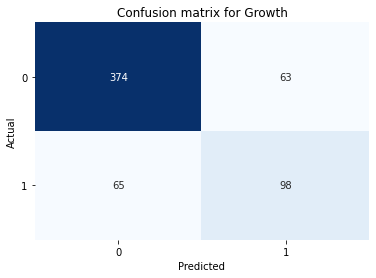

In [ ]:
print('Test accuracy is {}'.format(accuracy_score(test['growth'], test['growth_pred'])))
print('Classification report:')
print(classification_report(test['growth'], test['growth_pred']))

# plot confusion matrix
cm = confusion_matrix(test['growth'], test['growth_pred'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", 
        title="Confusion matrix for Growth")
plt.yticks(rotation=0)